<a href="https://colab.research.google.com/github/AvidahRai/PyTorch-Kaggle-Breast-Cancer-Cell-Segmentation/blob/main/1_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Breast Cancer Cell Segmentation


## Using Fully Convolution Networks

## A. Download dataset directly from Kaggle

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


My API key is stored in my Google Drive where I am going to retrieve for this session

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Create a temporary directory to store the Kaggle API key

In [ ]:
! mkdir ~/.kaggle

Copy the JSON file from drive to the temporary folder

In [ ]:
!cp /content/drive/MyDrive/kaggle_api_credentials/kaggle.json ~/.kaggle/kaggle.json

Change file permission

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

### Download the Breast Cancer Cell Segmentation dataset

In [ ]:
!kaggle datasets download andrewmvd/breast-cancer-cell-segmentation

100% 93.7M/93.7M [00:06<00:00, 19.2MB/s]
100% 93.7M/93.7M [00:06<00:00, 15.6MB/s]


Unzip dataset

In [ ]:
!unzip breast-cancer-cell-segmentation.zip

Archive:  breast-cancer-cell-segmentation.zip
  inflating: Images/ytma10_010704_benign1_ccd.tif  
  inflating: Images/ytma10_010704_benign1_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign2_ccd.tif  
  inflating: Images/ytma10_010704_benign2_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign3_ccd.tif  
  inflating: Images/ytma10_010704_benign3_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant1_ccd.tif  
  inflating: Images/ytma10_010704_malignant1_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant2_ccd.tif  
  inflating: Images/ytma10_010704_malignant2_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant3_ccd.tif  
  inflating: Images/ytma10_010704_malignant3_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign1_ccd.tif  
  inflating: Images/ytma12_010804_benign1_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign2_ccd.tif  
  inflating: Images/ytma12_010804_benign2_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign3_ccd.tif  
  inflating: Images/

## B. Create Dataset and Dataloaders

In [57]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

### Custom Dataset class

In [61]:
class BreastCancerCellSegmentDataset(Dataset):
    def __init__(self, image_dir, masks_dir, image_ext=".tif", masks_ext=".TIF", transform=None):
        self.image_dir = image_dir
        self.masks_dir = masks_dir
        self.image_ext = image_ext
        self.masks_ext = masks_ext
        self.transform = transform
        self.image_files = self.get_files(image_dir, image_ext)
        self.masks_files = self.get_files(masks_dir, masks_ext)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_filename = self.image_files[index]
        masks_filename = self.masks_files[index]

        image_path = os.path.join(self.image_dir, image_filename)
        masks_path = os.path.join(self.masks_dir, masks_filename)

        image = Image.open(image_path).convert("RGB")
        masks = Image.open(masks_path).convert("L")

        if self.transform:
            image = self.transform(image)
            masks = self.transform(masks)

        return image, masks

    def get_files(self, directory, file_ext):
        files = [file for file in os.listdir(directory) if file.endswith(file_ext)]
        files.sort()  # Sort the files
        return files

### Load Dataset and split into train, validation and test sets for cross-validation.

In [67]:
transform = transforms.Compose([
    transforms.RandomCrop((896, 768)),  # Random crop the images and masks
    transforms.RandomApply([
        transforms.RandomRotation(45),  # Randomly rotate the images and masks by up to 45 degrees
        transforms.RandomHorizontalFlip()  # Randomly flip the images and masks horizontally
    ], p=0.4),  # Apply the transformations with a 40% probability
    transforms.ToTensor()  # Convert images and masks to tensors
])

transform = transforms.Compose([
    transforms.Resize((896, 768)),  # Resize the images and masks
    transforms.ToTensor()  # Convert images and masks to tensors
])

# Load the entire dataset
image_dir_p = "Images"
image_file_ext = ".tif"
masks_dir_p = "Masks"
masks_file_ext = ".TIF"

dataset = BreastCancerCellSegmentDataset(
    image_dir_p,
    masks_dir_p,
    image_file_ext,
    masks_file_ext,
    transform=transform )

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Split into train and remaining (val + test)
train_indices, remaining_indices = train_test_split( range(len(dataset)), train_size=train_ratio, random_state=42, shuffle=True)

# Split remaining into val and test
val_indices, test_indices = train_test_split(
    remaining_indices, train_size=val_ratio/(val_ratio + test_ratio), random_state=42, shuffle=False)

# Create the train, val, and test datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(len(train_dataset), len(val_dataset), len(test_dataset))

34 12 12


In [46]:
for i in range(len(train_dataset)):
    image, masks = train_dataset[i]

for i in range(len(val_dataset)):
    image, masks = val_dataset[i]

for i in range(len(test_dataset)):
    image, masks = test_dataset[i]

### Visualize Random five samples

In [53]:
import random
import matplotlib.pyplot as plt

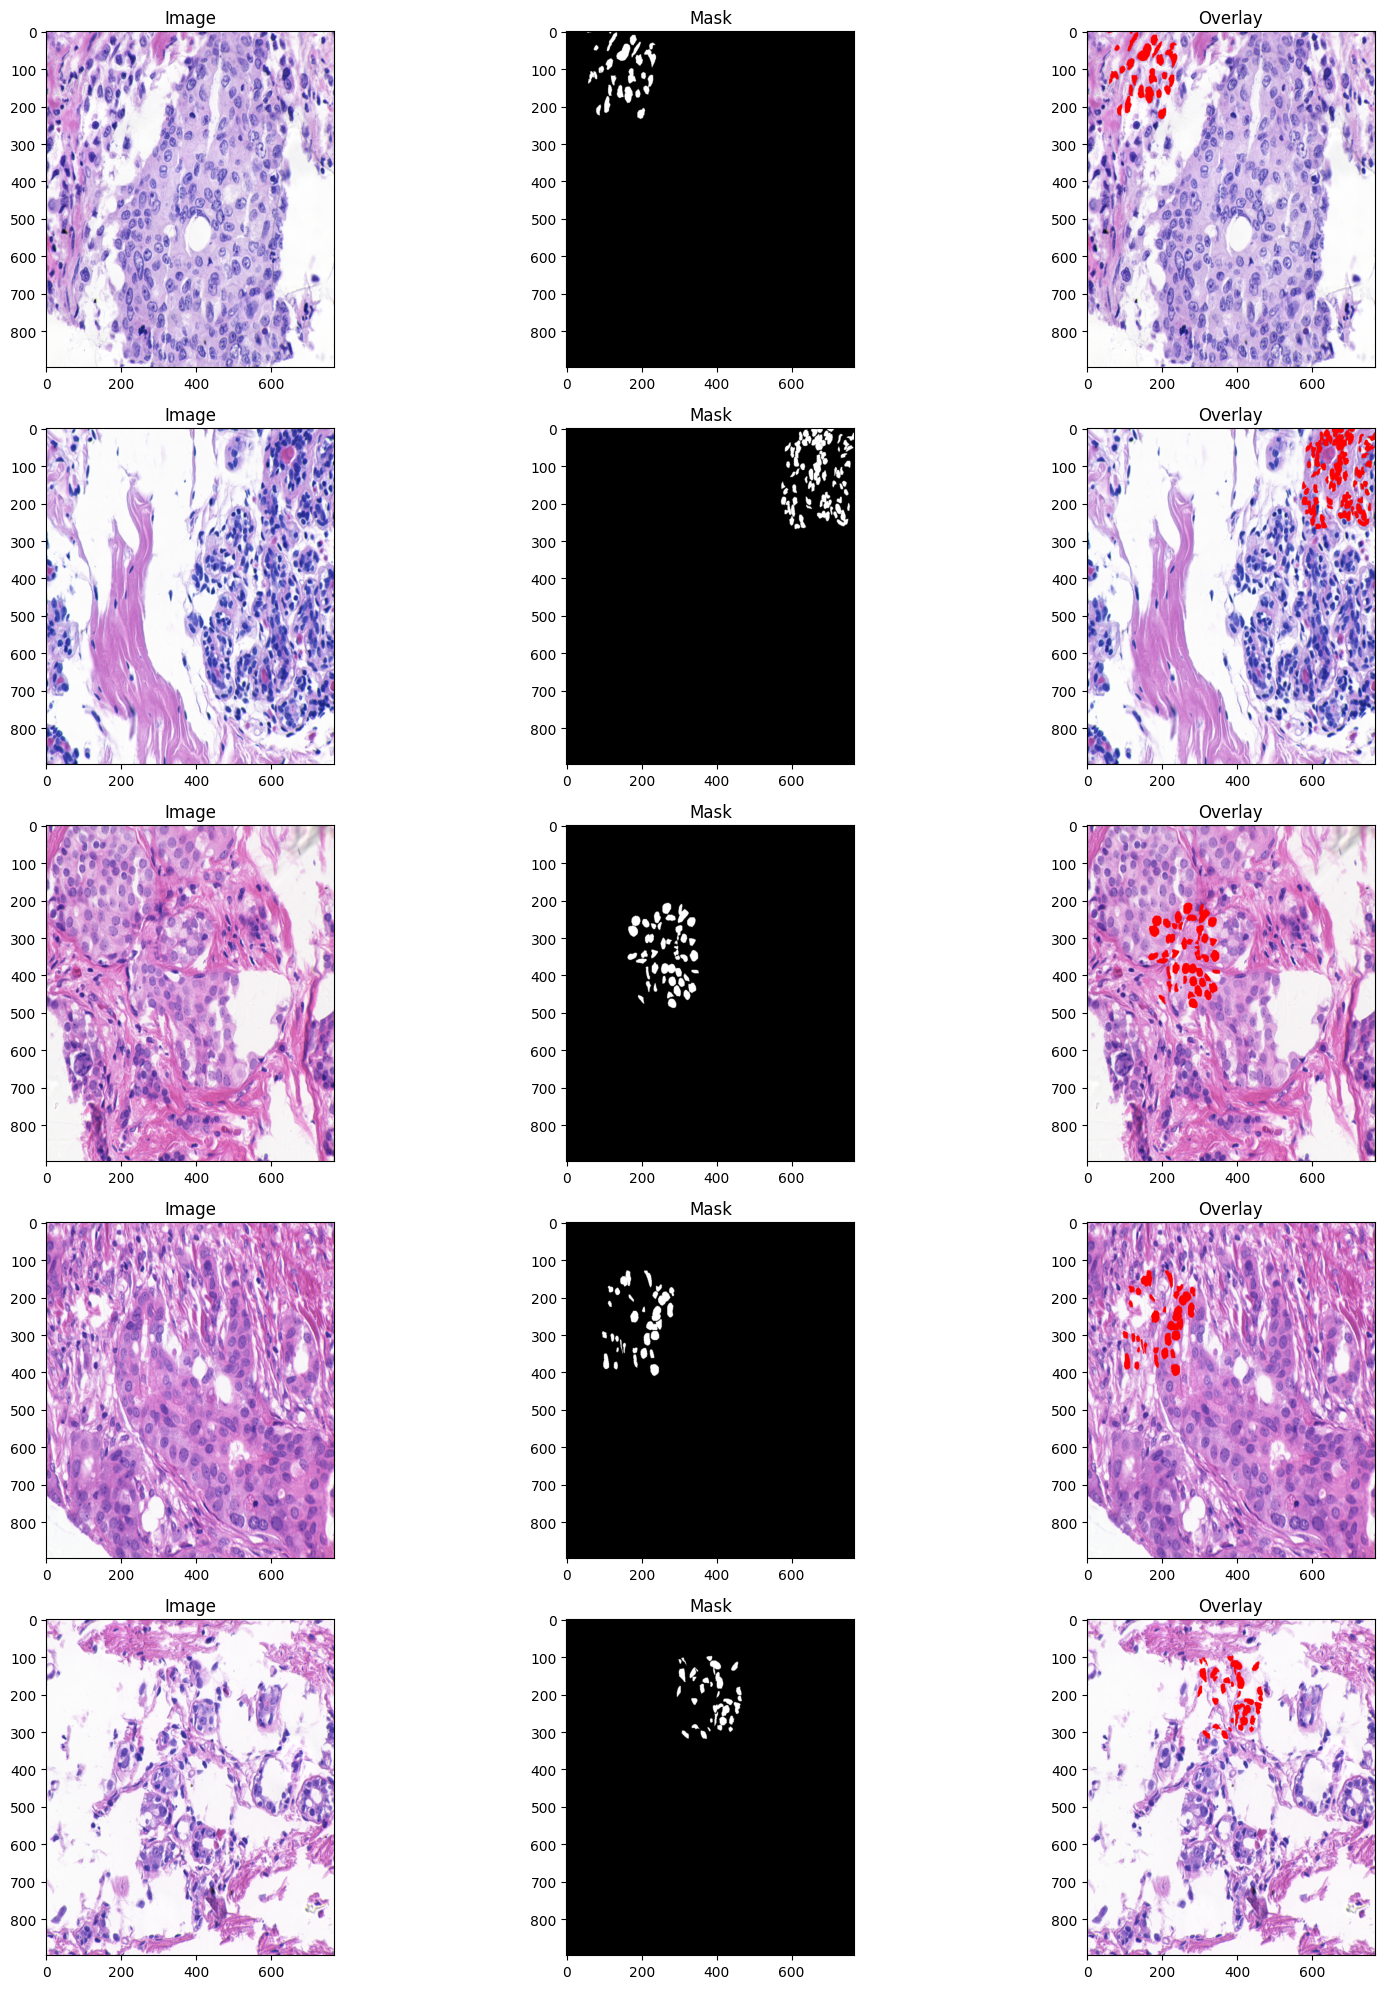

In [68]:
random_samples = random.sample(range(len(dataset)), 5)
fig, axes = plt.subplots(5, 3, figsize=(17, 20))

for i, idx in enumerate(random_samples):
    image, masks = dataset[idx]

    # Plot original image
    axes[i][0].imshow(image.permute(1, 2, 0))
    axes[i][0].set_title("Image")

    # Plot mask
    axes[i][1].imshow(masks.squeeze(), cmap='gray')
    axes[i][1].set_title("Mask")

    # Overlay mask on image
    overlay = image.permute(1, 2, 0).numpy()
    overlay[masks.squeeze() > 0] = [1, 0, 0]  # Overlay mask in red color
    axes[i][2].imshow(overlay)
    axes[i][2].set_title("Overlay")

fig.subplots_adjust(wspace=None, hspace=None)

plt.tight_layout()
plt.show()

### Custom Dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/2), shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=2)

## C. Create and intialize a model with FCN-8 architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
class FCN8(nn.Module):
    def __init__(self, num_classes):
        super(FCN8, self).__init__()
        vgg = models.vgg16()  # VGG16 model from torchvision

        # Encoder (VGG16 layers)
        self.features = vgg.features

        # FCN-8 specific layers
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        # Encoder (VGG16 layers)
        x = self.features(x)

        # FCN-8 specific layers
        pool3 = x
        pool4 = x

        # Score pool3 and pool4
        score_pool3 = self.score_pool3(pool3)
        score_pool4 = self.score_pool4(pool4)

        # Upsample scores
        upscore2 = self.upsample_2x(score_pool4)
        upscore8 = self.upsample_8x(upscore2)

        return upscore8[:, :, 19:19 + x.size(2), 19:19 + x.size(3)]  # Crop to match input size

### Instantiate Model

In [ ]:
# Instantiate the FCN-8 model
num_classes = 2  # Number of classes in the segmentation task
model = FCN8(num_classes)

# All parameters in the model are trainable
for param in model.parameters():
    param.requires_grad = True

# Print the model architecture
print(model)

FCN8(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Optimizer
The original FCN-8 paper by Long et al. (2015) used the Stochastic Gradient Descent (SGD) optimizer with momentum for training the FCN-8 model.

In [ ]:
import torch.optim as optim

learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

## D. Training


In [ ]:
import torch.nn.functional as F

### Loss functions
Two loss functions


1.   Intersection over Union
2.   Dice Coefficient



In [ ]:
def compute_iou_loss(predicted, target, smooth=1e-6):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    iou = (intersection + smooth) / (union + smooth)
    loss = 1 - iou
    return loss

In [ ]:
def compute_dice_loss(predicted, target, smooth=1e-6):
    intersection = torch.sum(predicted * target)
    dice = (2 * intersection + smooth) / (torch.sum(predicted) + torch.sum(target) + smooth)
    loss = 1 - dice
    return loss

### Train and Test functions

In [ ]:
def train_epoch(model, device, dataloader, optimizer):

    # Switch model to Train mode
    model.train()

    # Collect loss for epoch
    iou_loss_summation = 0.0
    dice_loss_summation = 0.0

    # Fetch data from dataloader
    for batch_id, (image, mask) in dataloader:

        # Pass the data to the set device
        image, mask = image.to(device), mask.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(image)

        # Compute loss
        iou_loss = compute_iou_loss(output, mask)
        dice_loss = compute_dice_loss(output, mask)

        # Backpropagation
        # Using IoU loss to perform backpropagation
        iou_loss.backward()

        # Update parameters
        optimizer.step()

        iou_loss_summation += iou_loss.item()
        dice_loss_summation += dice_loss.item()

    # average loss for epoch
    avg_iou_loss = iou_loss_summation/len(dataloader)
    avg_dice_loss = dice_loss_summation/len(dataloader)

    return avg_iou_loss, avg_dice_loss

In [ ]:
def validate_epoch(model, device, dataloader):

    # Switch model to evaluation mode
    model.eval()

    # Collect loss for epoch
    iou_loss_summation = 0.0
    dice_loss_summation = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for batch_id, (image, mask) in enumerate(dataloader):

            # Pass the data to the set device
            image, mask = image.to(device), mask.to(device)

            # Forward pass
            output = model(image)

            # Compute loss
            iou_loss = compute_iou_loss(output, mask)
            dice_loss = compute_dice_loss(output, mask)

            iou_loss_summation += iou_loss.item()
            dice_loss_summation += dice_loss.item()

    # Average loss for epoch
    avg_iou_loss = iou_loss_summation / len(dataloader)
    avg_dice_loss = dice_loss_summation / len(dataloader)

    return avg_iou_loss, avg_dice_loss

### Training Loop

In [ ]:
num_epochs = 50

train_losses = []
val_losses = []

In [44]:
# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/bin/bash: nvidia-smi: command not found


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_iou_loss, train_dice_loss = train_epoch(model, device, val_dataloader, optimizer)
    print("Train Loss (IoU/Dice): (%.4f, %.4f)" % (train_iou_loss, train_dice_loss))
    train_losses.append(train_iou_loss)

    # Validation phase
    val_iou_loss, val_dice_loss = validate_epoch(model, device, val_dataloader)
    print("Val Loss (IoU/Dice): (%.4f, %.4f)" % (val_iou_loss, val_dice_loss))
    val_losses.append(val_iou_loss)


### Visualise Training

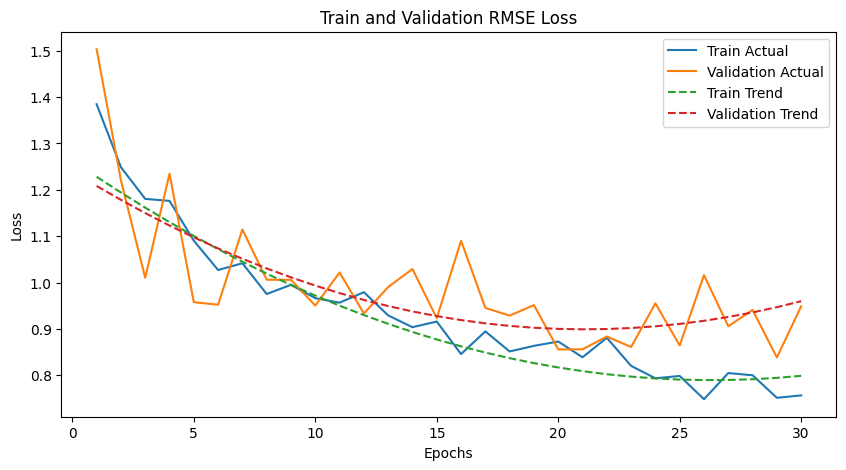

In [ ]:
import numpy as np

# Fit a 2nd degree polynomial to the train losses
train_poly_coefs = np.polyfit(range(len(train_losses)), train_losses, 2)
train_poly = np.poly1d(train_poly_coefs)

# Fit a 2nd degree polynomial to the validation losses
val_poly_coefs = np.polyfit(range(len(val_losses)), val_losses, 2)
val_poly = np.poly1d(val_poly_coefs)

# Generate x values for plotting the polynomials
x_values = range(1, len(train_losses)+1)

# Plot the train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(x_values, train_losses, label='Train Actual')
plt.plot(x_values, val_losses, label='Validation Actual')

# Plot the fitted polynomials
plt.plot(x_values, train_poly(x_values), label='Train Trend', linestyle='--')
plt.plot(x_values, val_poly(x_values), label='Validation Trend', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Intersect Over Union')
plt.title('Train and Validation IoU Loss')
plt.legend()
plt.show()

## E. Evaluations

### Quantitative

### Qualitative

## F. Summary